# Squeezing Color Bits
[Xu et al. in “Feature Squeezing: Detecting Adversarial Examples in Deep Neural Networks”](https://arxiv.org/abs/1704.01155).

# 1. 事前準備と確認

## ライブラリのインポート

In [1]:
from imagenet_util import *

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

## ResNet50 を生成

In [2]:
model = ResNet50(weights='imagenet')

## オリジナル画像のロード

In [3]:
original_image_path = '../../images/chihuahua2.jpg'
original_image = load_img(original_image_path, target_size=(224, 224))
original_image = img_to_array(original_image)

## オリジナル画像の推論と分類

In [4]:
# 推論
Y_hat = model.predict(np.expand_dims(preprocess_input(original_image.copy()), 0))

# 分類
original_class, original_name, original_score = get_top_pred(Y_hat)

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(original_name, original_score * 100))

Prediction: Chihuahua - score 67.11%


Run the test images through it.

## 敵対的サンプル (npy) のロード

In [5]:
# JSMA で生成した敵対的サンプルをロード
adv_image = np.load('../../data/chihuahua_jsma.npy')

## 敵対的サンプルの推論と分類

In [6]:
# 推論
Y_hat_adv = model.predict(np.expand_dims(preprocess_input(adv_image.copy()), 0))

# 分類
adv_class, adv_name, adv_score = get_top_pred(Y_hat_adv)

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(adv_name, adv_score * 100))

Prediction: weasel - score 23.78%


# 2. Squeezing Color Bits の実装と適用

## squeezing_color_bits 関数

In [7]:
def squeezing_color_bits(x0, bit_depth, original_max_value):
    # 正規化用の最大値を計算
    norm_max_value = 2 ** bit_depth - 1
    
    # 正規化
    x1 = x0 / original_max_value * norm_max_value

    # 小数第一位で四捨五入
    x2 = np.rint(x1)
    
    # 元のスケールに戻す
    x3 = x2 * original_max_value / norm_max_value

    return  x3

## squeezing_color_bits 関数のテスト

In [8]:
x0 = np.array(np.arange(16))
print(x0)
x3 = squeezing_color_bits(x0, bit_depth=2, original_max_value=2**4 - 1)
print(x3)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0.  0.  0.  5.  5.  5.  5.  5. 10. 10. 10. 10. 10. 15. 15. 15.]


## Squeezing Color Bits の適用

In [9]:
original_scb4_image = squeezing_color_bits(original_image, bit_depth=4, original_max_value=255)
adv_scb4_image = squeezing_color_bits(adv_image, bit_depth=4, original_max_value=255)
adv_scb2_image = squeezing_color_bits(adv_image, bit_depth=2, original_max_value=255)

## Squeezing Color Bits 適用後の「オリジナル画像」の推論と分類

In [10]:
# 推論
Y_hat_scb4 = model.predict(np.expand_dims(preprocess_input(original_scb4_image.copy()), 0))

# 分類
original_scb4_class, original_scb4_name, original_scb4_score = get_top_pred(Y_hat_scb4)

# 分類結果とスコアを表示
print('Prediction : {0} - score {1:.2f}%'.format(original_scb4_name, original_scb4_score * 100))

Prediction : Chihuahua - score 96.07%


## Squeezing Color Bits 適用後の「敵対的サンプル」の推論と分類

In [11]:
## bit_depth = 4 ## 
# 推論
Y_hat_adv_scb4 = model.predict(np.expand_dims(preprocess_input(adv_scb4_image.copy()), 0))

# 分類
adv_scb4_class, adv_scb4_name, adv_scb4_score = get_top_pred(Y_hat_adv_scb4)

# 分類結果とスコアを表示
print('Prediction (bit_depth = 4): {0} - score {1:.2f}%'.format(adv_scb4_name, adv_scb4_score * 100))

## bit_depth = 2 ## 
# 推論
Y_hat_adv_scb2 = model.predict(np.expand_dims(preprocess_input(adv_scb2_image.copy()), 0))

# 分類
adv_scb2_class, adv_scb2_name, adv_scb2_score = get_top_pred(Y_hat_adv_scb2)

# 分類結果とスコアを表示
print('Prediction (bit_depth = 2): {0} - score {1:.2f}%'.format(adv_scb2_name, adv_scb2_score * 100))

Prediction (bit_depth = 4): Chihuahua - score 87.29%
Prediction (bit_depth = 2): jigsaw_puzzle - score 97.37%


## Squeezing Color Bits 適用前後の「オリジナル画像」の表示

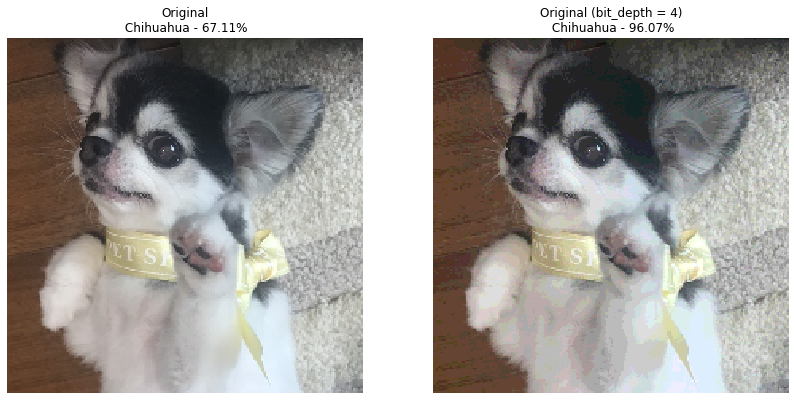

In [12]:
plt.figure(figsize=(14, 14))

# 敵対的サンプルを表示
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original\n {0} - {1:.2f}%'.format(original_name, original_score * 100))
plt.imshow(original_image/255.0)

# Median Smoothing 適用後の敵対的サンプルを表示
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Original (bit_depth = 4)\n {0} - {1:.2f}%'.format(original_scb4_name, original_scb4_score * 100))
plt.imshow(original_scb4_image/255.0)

## Squeezing Color Bits 適用前後の「敵対的サンプル」の表示

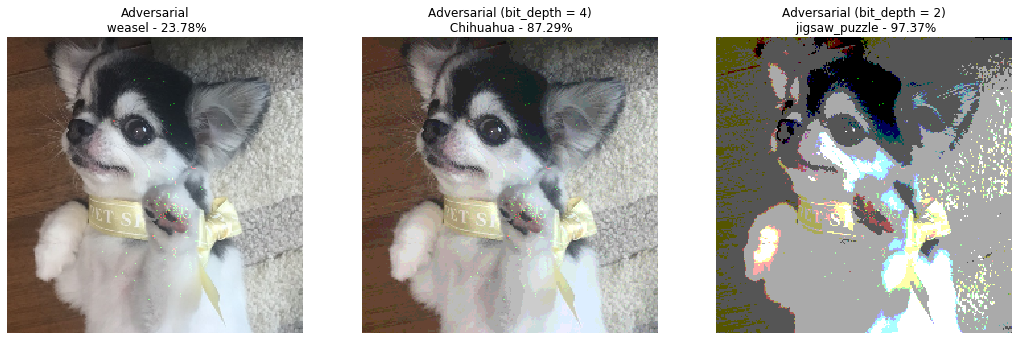

In [13]:
plt.figure(figsize=(18, 14))

# 敵対的サンプルを表示
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Adversarial\n {0} - {1:.2f}%'.format(adv_name, adv_score * 100))
plt.imshow(adv_image/255.0)

# bit_depth = 4 の敵対的サンプルを表示
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Adversarial (bit_depth = 4)\n {0} - {1:.2f}%'.format(adv_scb4_name, adv_scb4_score * 100))
plt.imshow(adv_scb4_image/255.0)

# bit_depth = 2 の敵対的サンプルを表示
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Adversarial (bit_depth = 2)\n {0} - {1:.2f}%'.format(adv_scb2_name, adv_scb2_score * 100))
plt.imshow(adv_scb2_image/255.0)

# 3. 攻撃検知のイメージ

## 攻撃検知用の関数

In [14]:
def anomaly_detection(non_preprocess_class, preprocessed_class):
    if non_preprocess_class == preprocessed_class:
        print('Normal.')
    else:
        print('Anomaly.')

## 正常ケース

In [15]:
anomaly_detection(original_class, original_scb4_class)

Normal.


## 異常ケース

In [16]:
anomaly_detection(adv_class, adv_scb4_class)

Anomaly.
